In [50]:
import pandas as pd

dataset = pd.read_csv('student_lifestyle_100k.csv')
dataset['Gender'] = dataset['Gender'].astype('category')
dataset['Department'] = dataset['Department'].astype('category')
dataset['Stress_Level'] = dataset['Stress_Level'].astype('category')

In [51]:
# Aufteilen nach True und False in der Spalte Depression
depressed = dataset[dataset['Depression']]
not_depressed = dataset[~dataset['Depression']]

# zufällige negative Stichproben ziehen (gleiche Anzahl wie positive Fälle)
not_depressed_sample = not_depressed.sample(n=len(depressed), random_state=42)

# Datensatz zusammensetzen
balanced_dataset = pd.concat([depressed, not_depressed_sample])

x = balanced_dataset.loc[:, 'Age':'Stress_Level']
y = balanced_dataset['Depression']

In [52]:
import torch

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, TargetEncoder
from torch.utils.data import TensorDataset, DataLoader

# Seed für Reproduzierbarkeit setzen
torch.manual_seed(42)
generator = torch.Generator().manual_seed(42) # für DataLoader-Shuffling

# Aufteilen in Training, Validierung und Test (60% Train, 20% Val, 20% Test)
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.4, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Spalten nach Typ trennen
target_encode_cols = ['Department']
onehot_cols = [c for c in x.select_dtypes(include='category').columns if c not in target_encode_cols]
numeric_cols = x.select_dtypes(include=['number', 'bool']).columns.tolist()

# Preprocessing-Transformer (numerisch: RobustScaler, kategorisch: OneHotEncoder, TargetEncoding für Department)
preprocessor = ColumnTransformer([
    ("numeric",     RobustScaler(),                           numeric_cols),
    ("onehot",      OneHotEncoder(drop='first', sparse_output=False), onehot_cols),
    ("target_enc",  TargetEncoder(target_type='binary', smooth='auto'), target_encode_cols),
])

# Fit-Transform auf Trainingsdaten, Transform auf Val-/Testdaten
x_train_scaled = preprocessor.fit_transform(x_train, y_train)
x_val_scaled = preprocessor.transform(x_val)
x_test_scaled = preprocessor.transform(x_test)

# setzen der neuen Feature-Anzahl nach Preprocessing
input_dim = x_train_scaled.shape[1]
output_dim = 1 # binäre Klassifikation (Depression ja/nein)


# Erstellen von DataLoadern für Training, Validierung und Test
batch_size = 128
train_loader = DataLoader(TensorDataset(torch.FloatTensor(x_train_scaled), torch.FloatTensor(y_train.values).view(-1, 1)), batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(x_val_scaled), torch.FloatTensor(y_val.values).view(-1, 1)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(x_test_scaled), torch.FloatTensor(y_test.values).view(-1, 1)), batch_size=batch_size, shuffle=False)

print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches per epoch: 95
Validation batches: 32
Test batches: 32


/\ Datensatz vorbereiten

\\/ Modelle definieren und Grundlage für Training legen

In [53]:
import torch.nn as nn

class FlexibleClassifier(nn.Module):
    """
    Flexible neural network that can be configured with different architectures.
    Supports variable depth and layer dimensions.
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        """
        Args:
            input_dim: Number of input features
            hidden_dims: List of hidden layer dimensions, e.g., [64, 32]
            output_dim: Number of output classes
            dropout_rate: Dropout probability
        """
        super().__init__()
        
        # Build layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim)) # Normalisierungsschicht hinzugefügt
            layers.append(nn.LeakyReLU(0.1)) # LeakyReLU anstelle von ReLU 
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [54]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item() * batch_X.size(0)
        # Vorhersagen in binäre Klassen umwandeln (Schwellenwert 0.5) - wird benötigt wegen BCEWithLogitsLoss
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    
    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion):
    """Evaluate the model"""
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            eval_loss += loss.item() * batch_X.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    
    avg_loss = eval_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

/\ Modelle definieren und Grundlage für Training legen

\\/ Spezifischer Code für das Hyperparameter Tuning

In [55]:
import optuna

def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.01, weight_decay=0.0, patience=15, trial=None):
    """Complete training loop"""
    # Binary Croos-Entropy mit Logits Loss ist für binäre Klassifikation geeignet
    # Es erwartet rohe Logits als Eingabe und berechnet intern die Sigmoid-Aktivierung, bevor der Verlust berechnet wird.
    # Für mehrere Output-Klassen (z.B. bei Multi-Label-Klassifikation) wird CrossEntropyLoss verwendet, das die Softmax-Aktivierung intern anwendet.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
        if trial is not None:
            trial.report(val_acc, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
    
    return best_val_acc, best_epoch

In [56]:
def objective(trial):
    """
    Objective function for Optuna to optimize.
    Returns the best validation accuracy for this hyperparameter configuration.
    """
    # Define the search space
    n_layers = trial.suggest_int('n_layers', 1, 4)
    hidden_dims = []
    for i in range(n_layers):
        dim = trial.suggest_categorical(f'hidden_dim_layer_{i}', [32, 64, 128, 256])
        hidden_dims.append(dim)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)    
    
    # Training the model with the sampled hyperparameters
    model = FlexibleClassifier(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=output_dim,dropout_rate=dropout_rate)        
    best_val_acc, best_epoch = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=learning_rate,
        weight_decay=weight_decay,
        trial=trial  # For Optuna pruning
    )

    # prüfen, ob Variable für Bestscore existiert, sonst initialisieren
    try: 
        best_global_score
    except NameError: 
        best_global_score = 0.0

    if best_val_acc > best_global_score:
        best_global_score = best_val_acc

        torch.save({
            "model_state_dict": model.state_dict(),
            "params": trial.params,
            "val_acc": best_val_acc,
            "best_epoch": best_epoch
        }, "best_optuna_model.pt")

    return best_val_acc

In [57]:
study = optuna.create_study(
    direction='maximize',
    study_name='depression_classification',
    storage='sqlite:///optuna_depression.db',
    load_if_exists=True,
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=10
    )
)

# wenn es schon Trials gibt, n_trials = 0, damit nicht nochmal optimiert wird
n_trials = 50 if len(study.trials) == 0 else 0

study.optimize(
    objective, 
    n_trials=n_trials, 
    show_progress_bar=True
)

best_model = study.best_trial

[I 2026-02-28 09:55:47,960] A new study created in RDB with name: depression_classification


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-28 09:56:09,279] Trial 0 finished with value: 0.6881987577639752 and parameters: {'n_layers': 3, 'hidden_dim_layer_0': 32, 'hidden_dim_layer_1': 64, 'hidden_dim_layer_2': 128, 'weight_decay': 0.00018805250415346154, 'learning_rate': 0.0003223353596936687, 'dropout_rate': 0.4496319367213733}. Best is trial 0 with value: 0.6881987577639752.
[I 2026-02-28 09:56:28,371] Trial 1 finished with value: 0.6817391304347826 and parameters: {'n_layers': 4, 'hidden_dim_layer_0': 256, 'hidden_dim_layer_1': 256, 'hidden_dim_layer_2': 128, 'hidden_dim_layer_3': 32, 'weight_decay': 5.911017984497547e-05, 'learning_rate': 0.002476391144449074, 'dropout_rate': 0.24148027821563556}. Best is trial 0 with value: 0.6881987577639752.
[I 2026-02-28 09:56:53,447] Trial 2 finished with value: 0.6790062111801243 and parameters: {'n_layers': 3, 'hidden_dim_layer_0': 256, 'hidden_dim_layer_1': 256, 'hidden_dim_layer_2': 64, 'weight_decay': 2.1473307354416765e-05, 'learning_rate': 7.613379916633032e-05, '

In [58]:
checkpoint = torch.load("best_optuna_model.pt")

params = checkpoint["params"]

hidden_dims = [
    params[f"hidden_dim_layer_{i}"]
    for i in range(params["n_layers"])
]

best_model = FlexibleClassifier(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    output_dim=output_dim,
    dropout_rate=params["dropout_rate"]
)

best_model.load_state_dict(checkpoint["model_state_dict"])
best_model.eval()

print("Loaded Best Model Accuracy:", checkpoint["val_acc"])

Loaded Best Model Accuracy: 0.6857142857142857


/\ Spezifischer Code für das Hyperparameter Tuning

\\/ Auswertung

               precision    recall  f1-score   support

Not Depressed       0.67      0.73      0.70      2013
    Depressed       0.70      0.64      0.67      2012

     accuracy                           0.68      4025
    macro avg       0.68      0.68      0.68      4025
 weighted avg       0.68      0.68      0.68      4025



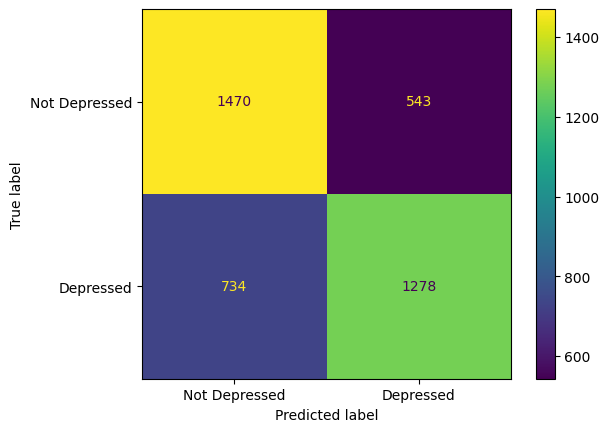

In [59]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

with torch.no_grad():
    test_outputs = best_model(torch.FloatTensor(x_test_scaled))
    y_pred = (torch.sigmoid(test_outputs) > 0.5).int().numpy()

target_names = ['Not Depressed', 'Depressed']
print(classification_report(y_test, y_pred, target_names=target_names))


ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names)